In [1]:
## SIMULATION PARAMETERS
verbosity         = 6        # Set debug print statement verbosity level (0 = Standard, -1 = Off)
use_mass_units    = True     # Toggle whether calculations / results are given in units of pi-axion mass (True) or eV (False)
use_natural_units = True     # Toggle whether calculations / results are given in c = h = G = 1 (True) or SI units (False)   || NOTE: full SI/phsyical unit support is still WIP!!
save_output_files = True     # Toggle whether or not the results from this notebook run are written to a data directory

config_name = 'axion_debug'   # Descriptive name for the given parameter case. Output files will be saved in a directory with this name.
seed = None                  # rng_seed, integer value (None for random)
#seed = bbbcfee89c436a9c11885e23159ef57a33e53985
num_cores = 100              # Number of parallel threads available
#density = 1e22                # Local DM energy density (in [Gev/cm^3])
use_tex_format = True

In [2]:
# System Configuration Printouts
from piaxi_utils import version, default_output_directory

data_path = default_output_directory
version   = version

if verbosity >= 2:
    print('version %s' % version)
    print('save path: %s' % data_path)

version v3.2.5
save path: ~/scratch


In [3]:
# Imports and Initialization
import numpy as np
import pandas as pd
from collections import OrderedDict
from scipy.integrate import solve_ivp
from scipy.signal import spectrogram
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import matplotlib.image as image
import matplotlib.cm as cm
from piaxi_numerics import set_param_space, solve_piaxi_system
from piaxi_utils import *
from piaxiverse import *
import os

debug_level = verbosity
unitful_masses = True    # Toggle whether to provide unitful [eV] masses vs. mass-ratio [m_unit] values for calculations (Default: True)
unitful_k = False        # Toggle whether k values are defined unitfully [eV] vs. units of mass-ratio [m_unit] (Default: False)

rng, rng_seed = get_rng(seed=seed, verbosity=verbosity)

rng_seed: 314837075430813967861595655599910396673


In [4]:
# LaTeX Formatting for Plots
if use_tex_format:
    plt.rcParams.update({
        'text.usetex': True,
        'font.family': 'serif',
    })
    plt.rc('text', usetex=True)
    plt.rc('text.latex', preamble=r'\usepackage{amsmath}')

    SMALL_SIZE = 8
    MEDIUM_SIZE = 16
    BIGGER_SIZE = 20

    plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
    '''plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the x tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the y tick labels
    plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
    plt.rc('figure', labelsize=BIGGER_SIZE, titlesize=BIGGER_SIZE)  # fontsize of the figure title'''

In [5]:
# Unitful fundamental constants
c_raw = c = np.float64(2.998e10)    # Speed of light in a vacuum [cm/s]
h_raw = h = np.float64(4.136e-15)   # Planck's constant [eV/Hz]
G_raw = G = np.float64(1.0693e-19)  # Newtonian constant [cm^5 /(eV s^4)]
manual_set = False
if manual_set: # Manually toggle units
    unitful_c = False
    unitful_h = False
    unitful_G = False
if use_natural_units:
    unitful_c = unitful_h = unitful_G = False
else:
    unitful_c = unitful_h = unitful_G = True

# values to use in calculations in order to ensure correct units
c_u = c if unitful_c else 1.
h_u = h if unitful_h else 1.
G_u = G if unitful_G else 1.

In [6]:
# Set constants of model
e    = 0.3      # dimensionless electron charge
F    = 2e15     # pi-axion decay constant (GeV) >= 10^11
#F    = 1e13     # pi-axion decay constant (GeV) >= 10^11
p_t  = 1e22     # total local DM density (GeV/cm^3)
#p_t = 1e20
#p_unit = 1.906e-12
dimensionful_p = not(use_natural_units)
p_unit = (c_raw*h_raw)**3 if not(dimensionful_p) else 1.   # convert densities from units of [1/cm^3] to [eV^3]
## --> TODO: Could/Should we support spatially dependent distributions?

## Tuneable constants
# millicharge, vary to enable/disable charged species (10e-15 = OFF, 10e-25 = ON)
#eps  = 1e-25   # (unitless)
eps  = 1

# Coupling constants
#L3   = 1e11    # (GeV)
L3   = 1
#L4   = 1e11    # (GeV)
L4   = 2e7
l1   = 1       #
l2   = 1       #
l3   = 1       #
l4   = 1       #

# Unit scaling:
GeV  = 1e9     # GeV -> eV
#GeV = 1
F   *= GeV
p_t *= GeV
p_t *= p_unit  # 1/cm^3 -> (eV/hc)^3
L3  *= GeV
L4  *= GeV

In [7]:
## Dark SM Parameters
sample_qmass = False # TODO
sample_qcons = False
# Mass scaling parameters
m_scale = 5e-37            # dark quark mass scale (eV) <= 10-20

# SM quark masses for all 3 generations
qm = m_scale*np.array([1., 2., 40.]) if not sample_qmass else m_scale*np.array([0., 0., 0.]) # TODO

# dSM quark scaling constants (up, down, strange, charm, bottom, top) sampled from uniform distribution [0.7, 1.3]
qc = np.array([0., 0.5, 0.5, 0., 0., 0.]) if not sample_qcons else rng.uniform(0.7, 1.3, (6,))
#qc = np.array([1., 1., 1., 1., 1., 1.]) if not sample_qcons else rng.uniform(0.7, 1.3, (6,))

# Dark quark masses (up, down, strange, charm, bottom, top)
dqm = np.array([qm[0]*qc[0], qm[0]*qc[1], qm[1]*qc[2], qm[1]*qc[3], qm[2]*qc[4], qm[2]*qc[5]])

# Scaling parameters
xi     = np.array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.])  # Charged species scaling paramters
eps_c  = np.array([+1., +1., +1., -1., -1., -1., -1., +1., -1.])  # Millicharge sign

In [8]:
# Time domain
# TODO: How many oscillations do we want to capture in the time period?
#       Do we want to run each simulation until it hits time t' or until it completes T oscillations?
t_span = [0, 30]   # Units of 1/m_u
#t_N    = 300       # Number of timesteps
t_N = 300
t_sens = 0.1       # sensitivity for calculating time-averaged values

# k values
# TODO: Should we run k up until we hit the cutoff limit? If not, what limit?
use_k_eq_0 = False     # Toggle whether or not k = 0 is included in the numerics (div. by 0 error possible if on)
k_min = 0 if use_k_eq_0 else 1
k_max = 300
k_span = [k_min, k_max]  # TODO: replace with the appropriate values
k_res = 0.1                            # k-mode granularity
k_N = int((1./k_res)*max((k_max - k_min), 0) + 1)    # Number of k-modes
#k_N = 200

In [9]:
# Initial Conditions
A_0    = 1.0
Adot_0 = 1.0

A_pm   = +1       # specify A± case (+1 or -1)
A_sens = 1.0      # sensitivity for classification of resonance conditions
em_bg  = 1.0      # Photon field background

In [10]:
# Toggle whether mass-energy values should be computed in units of eV (False) or pi-axion mass (True)
# (by default, k is defined in units of [m_u] whereas m is defined in units of [eV], so their scaling logic is inverted)
unitful_amps   = unitful_m = unitful_masses
rescale_m      = use_mass_units if unitful_masses else not(use_mass_units)
rescale_k      = not(rescale_m) if unitful_masses else rescale_m
rescale_amps   = use_mass_units if unitful_amps else not(use_mass_units)

In [11]:
# Define pi-axiverse mass species
m_r, m_n, m_c, counts, masks = define_mass_species(qm=qm, qc=qc, F=F, e=e, eps=eps, eps_c=eps_c, xi=xi)
N_r, N_n, N_c = counts

In [12]:
## Get variables of model

# Populate masses for real, complex, and charged species (given in units of eV)
m, m_u = init_masses(m_r, m_n, m_c, natural_units=use_natural_units, c=c, verbosity=verbosity)
# Handle unit rescaling logic
m_unit = m_u

m0     = m0_f(m_u, c_u, rescale_m, unitful_m)      # Desired units  (m --> m_u)
m0_raw = m0_f(m_u, c_raw, True, unitful_m)    # Physical units (eV/c^2)
k0     = k0_f(m_u, c_u, rescale_k, unitful_m)      # Desired units  (k --> m_u)
k0_raw = k0_f(m_u, c_raw, True, unitful_m)    # Physical units (eV/c)
t0     = t0_f(m_u, h_u, rescale_m, unitful_m)      # Desired units  (t --> 1/m_u)
t0_raw = t0_f(m_u, h_raw, True, unitful_m)    # Physical units (s)

if verbosity >= 2:
    print('c = %.4g  | c_u = %.2g | c_raw = %.2g' % (c, c_u, c_raw))
    print('h = %.4g  | h_u = %.2g | h_raw = %.2g' % (h, h_u, h_raw))
    print('G = %.4g  | G_u = %.2g | G_raw = %.2g' % (G, G_u, G_raw))
    print('m_u       : %.2g' % m_u)
    print('m_0       : %.2g' % m0)
    print('m_0 (raw) : %.2g' % m0_raw)
    print('k_0       : %.2g' % k0)
    print('k_0 (raw) : %.2g' % k0_raw)
    print('t_0       : %.2g' % t0)
    print('t_0 (raw) : %.2g' % t0_raw)

## Populate pi-axion dark matter energy densities
p = init_densities(masks, p_t=p_t, normalized_subdens=True)

## Populate (initial) pi-axion dark matter mass-amplitudes for each species, optional units of [eV/c]
amps = init_amplitudes(m, p, m_unit=m_u, h=h, c=c, mass_units=use_mass_units, natural_units=use_natural_units, unitful_amps=unitful_masses, rescale_amps=rescale_amps, verbosity=verbosity)

freeze_Theta = False
if freeze_Theta:
    Th_in = np.array([np.ma.masked_where(masks[0], np.full_like(masks[0], np.pi, dtype=float)).compressed(),
                      np.ma.masked_where(masks[1], np.full_like(masks[1], np.pi, dtype=float)).compressed(),
                      np.ma.masked_where(masks[2], np.full_like(masks[2], np.pi, dtype=float)).compressed()], dtype=object)
    sample_Theta = False
else:
    Th_in = None
    sample_Theta = True

# Populate and sample local and global phases from normal distribution, between 0 and 2pi
d, Th = init_phases(masks, rng=rng, sample_delta=True, sample_Theta=sample_Theta, Theta_in=Th_in, verbosity=verbosity, sample_dist='uniform')

# For performance gains, omit fully non-existant species from the numerics
m    = trim_masked_arrays(m)
p    = trim_masked_arrays(p)
amps = trim_masked_arrays(amps)
Th   = trim_masked_arrays(Th)
d    = trim_masked_arrays(d)

m_unit:   1.224744871391589e-06
m (raw):
 [array([], dtype=float64) array([1.22474487e-06]) array([], dtype=float64)]
m (out):
 [array([], dtype=float64) array([1.22474487e-06]) array([], dtype=float64)]
c = 2.998e+10  | c_u = 1 | c_raw = 3e+10
h = 4.136e-15  | h_u = 1 | h_raw = 4.1e-15
G = 1.069e-19  | G_u = 1 | G_raw = 1.1e-19
m_u       : 1.2e-06
m_0       : 8.2e+05
m_0 (raw) : 9.1e-16
k_0       : 1
k_0 (raw) : 4.1e-17
t_0       : 8.2e+05
t_0 (raw) : 3.4e-09
amps (raw):
 [array([], dtype=float64) array([1.18836911e+15]) array([], dtype=float64)]
amps (out):
 [array([], dtype=float64) array([9.70299314e+20]) array([], dtype=float64)]
Sample delta?   True (uniform distribution)
delta (out):
 [array([], dtype=float64) array([0.49115845]) array([], dtype=float64)]
Sample Theta?   True (uniform distribution)
Theta (out):
 [array([], dtype=float64) array([0.96167281]) array([], dtype=float64)]


In [13]:
## Define the system of ODEs
# TODO: Finish defining time-dependent functions P(t), B(t), C(t), D(t) here
#       - Verify they are the correct form, double check all signs and factors of 2
# NOTE: Using cosine definitons for amplitudes
#       i = {0,1,2} correspond to {pi_0, pi, pi_±} respectively

# Rescale all eV unit constants to unit mass
#rescale_consts = False
rescale_consts = rescale_m if unitful_masses else not(rescale_m)
L3_sc = abs(L3) if not rescale_consts else L3 / m_unit
L4_sc = abs(L4) if not rescale_consts else L4 / m_unit
F_sc  = abs(F)  if not rescale_consts else  F / m_unit

units = get_units(unitful_m, rescale_m, unitful_k, rescale_k, unitful_amps, rescale_amps, rescale_consts, dimensionful_p, unitful_c, unitful_h, unitful_G, use_mass_units, verbosity=verbosity)
print_params(units, m=m, p=p, amps=amps, Th=Th, d=d, m_q=m_scale, m_0=m0, m_u=m_u, natural_units=use_natural_units, verbosity=verbosity)

# Shorthand helper function for oscillatory time-dependent terms
# (time is assumed to be defined in units of [1/m_u] always)
phi = lambda t, s, i, m=m, d=d, t0=t0: (m[s][i]*t*t0) + d[s][i]
#phi = lambda t, s, i, m=m, d=d, M=(1./m_unit if unitful_masses and not rescale_m else 1.): (m[s][i]*M)*t + d[s][i]

# Define coefficient functions to clean up differential equation representation
P = lambda t, l3=l3, L3=L3_sc, l4=l4, L4=L4_sc, eps=eps, amps=amps, m=m, M=m0, d=d, Th=Th, c=c_u, h=h_u, G=G_u, phi=phi, np=np: \
           2*l3/(L3**2) * eps**2 * (np.sum([amps[2][i]*amps[2][j]/c**2 * np.cos(phi(t,2,i))*np.cos(phi(t,2,j)) * np.cos(Th[2][i]-Th[2][j]) \
                                            for i in range(len(m[2])) for j in range(len(m[2]))], axis=0)) + \
           2*l4/(L4**2) * eps**2 * (np.sum([amps[1][i]*amps[1][j]/c**2 * np.cos(phi(t,1,i))*np.cos(phi(t,1,j)) * np.cos(Th[1][i]-Th[1][j]) \
                                            for i in range(len(m[1])) for j in range(len(m[1]))], axis=0) + \
                                    np.sum([amps[0][i]*amps[0][j]/c**2 * np.cos(phi(t,0,i))*np.cos(phi(t,0,j)) \
                                            for i in range(len(m[0])) for j in range(len(m[0]))], axis=0) + \
                                  2*np.sum([amps[0][i]*amps[1][j]/c**2 * np.cos(phi(t,0,i))*np.cos(phi(t,1,j)) * np.cos(Th[1][j]) \
                                            for i in range(len(m[0])) for j in range(len(m[1]))], axis=0))

B = lambda t, l3=l3, L3=L3_sc, l4=l4, L4=L4_sc, eps=eps, amps=amps, m=m, M=m0, d=d, Th=Th, c=c_u, h=h_u, G=G_u, phi=phi, np=np: \
            (-1)*2*l3/(L3**2) * eps**2 * (np.sum([amps[2][i]*amps[2][j]/c**2 * np.cos(Th[2][i]-Th[2][j])  * \
                                                  ((m[2][i]*M/c**2) * np.sin(phi(t,2,i)) * np.cos(phi(t,2,j)) + \
                                                   (m[2][j]*M/c**2) * np.cos(phi(t,2,i)) * np.sin(phi(t,2,j))) \
                                                  for i in range(len(m[2])) for j in range(len(m[2]))], axis=0)) + \
            (-1)*2*l4/(L4**2) * eps**2 * (np.sum([amps[0][i]*amps[0][j]/c**2 * ((m[0][i]*M/c**2) * np.sin(phi(t,0,i)) * np.cos(phi(t,0,j)) + \
                                                                                  (m[0][j]*M/c**2) * np.cos(phi(t,0,i)) * np.sin(phi(t,0,j))) \
                                                  for i in range(len(m[0])) for j in range(len(m[0]))], axis=0) + \
                                                 np.sum([amps[1][i]*amps[1][j]/c**2 * np.cos(Th[1][i]-Th[1][j])  * \
                                                         ((m[1][i]*M/c**2) * np.sin(phi(t,1,i)) * np.cos(phi(t,1,j)) + \
                                                          (m[1][j]*M/c**2) * np.cos(phi(t,1,i)) * np.sin(phi(t,1,j))) \
                                                         for i in range(len(m[1])) for j in range(len(m[1]))], axis=0) + \
                                                 np.sum([np.abs(amps[0][i]*amps[1][j]/c**2) * np.cos(Th[1][j]) * \
                                                         ((m[0][i]*M/c**2) * np.sin(phi(t,0,i)) * np.cos(phi(t,1,j)) + \
                                                          (m[1][j]*M/c**2) * np.cos(phi(t,0,i)) * np.sin(phi(t,1,j))) \
                                                         for i in range(len(m[0])) for j in range(len(m[1]))], axis=0))

C = lambda t, pm, l1=l1, F=F_sc, eps=eps, amps=amps, m=m, M=m0, d=d, c=c_u, h=h_u, G=G_u, phi=phi, np=np: \
            (-1) * pm * (2*l1 / F) * eps**2 * np.sum([amps[0][i]/c**2 * (m[0][i]*M/c**2) * np.sin(phi(t,0,i)) \
                                                      for i in range(len(m[0]))], axis=0)

D = lambda t, l2=l2, e=e, eps=eps, amps=amps, m=m, M=m0, d=d, Th=Th, c=c_u, h=h_u, G=G_u, phi=phi, np=np: \
            l2 * eps**2 * e**2 * np.sum([amps[2][i]*amps[2][j]/c**2 * np.cos(phi(t,2,i))*np.cos(phi(t,2,j)) * np.cos(Th[2][i]-Th[2][j]) \
                                         for i in range(len(m[2])) for j in range(len(m[2]))], axis=0)

use_mass_units:  True || use_natural_units: True
----------------------------------------------------
unitful_masses:  True | [eV]
rescale_m:       True | [eV] -> [m_u]
unitful_k:      False | [m_u]
rescale_k:      False 
unitful_amps:    True | [eV]
rescale_amps:    True | [eV] -> [m_u]
rescale_consts:  True | [eV] -> [m_u]
----------------------------------------------------
m_dQCD = 5e-37 [eV]
m_u = 1.225e-06 [eV]
m [m_u]
  m_(0): N/A
  m_(π): 1.000e+00
  m_(±): N/A
rho [eV^4]
  m_(0): N/A
  m_(π): 1.059e+18
  m_(±): N/A
amp [m_u]
  m_(0): N/A
  m_(π): 9.703e+20
  m_(±): N/A
Theta [π]
  m_(0): N/A
  m_(π): 0.31
  m_(±): N/A
delta [π]
  m_(0): N/A
  m_(π): 0.16
  m_(±): N/A


In [14]:
override_coefficients = True
if override_coefficients:
    #P = P_off
    #B = B_off
    #D = D_off
    #C = C_off
    override_coefficients = True

In [15]:
# Prepare the numerical integration
k_values, k_step = np.linspace(k_span[0], k_span[1], k_N, retstep=True)
#k_values = np.linspace(1./100, 10, 100)

# Initialize an array to store the solutions
t, t_step = np.linspace(t_span[0], t_span[1], t_N, retstep=True)  # Array of times at which to evaluate, t > 0
#t = t[1:]

# Classification sensitivity threshold
res_con = 1000
#res_con = max(100,1./A_sens)

# Numerical Integration method (to be passed to solve_ivp)
int_method = 'RK45'

# Collect all input parameters
parameters = {'e': e, 'F': F, 'p_t': p_t, 'eps': eps, 'L3': L3, 'L4': L4, 'l1': l1, 'l2': l2, 'l3': l3, 'l4': l4, 'res_con': res_con,
              'A_0': A_0, 'Adot_0': Adot_0, 'A_pm': A_pm, 't_sens': t_sens, 'A_sens': A_sens,
              'qm': qm, 'qc': qc, 'dqm': dqm, 'eps_c': eps_c, 'xi': xi, 'm_0': m0, 'm_u': m_unit, 'm_scale': m_scale, 'p_unit': p_unit,
              'm_r': m[0], 'm_n': m[1], 'm_c': m[2], 'p_r': p[0], 'p_n': p[1], 'p_c': p[2], 'Th_r': Th[0], 'Th_n': Th[1], 'Th_c': Th[2],
              'amp_r': amps[0], 'amp_n': amps[1], 'amp_c': amps[2], 'd_r': d[0], 'd_n': d[1], 'd_c': d[2], 'k_0': k0,
              'unitful_m': unitful_masses, 'rescale_m': rescale_m, 'unitful_amps': unitful_amps, 'rescale_amps': rescale_amps, 
              'unitful_k': unitful_k, 'rescale_k': rescale_k, 'rescale_consts': rescale_consts, 'h': h, 'c': c, 'G': G, 'seed': rng_seed, 
              'dimensionful_p': dimensionful_p, 'use_natural_units': use_natural_units, 'use_mass_units': use_mass_units, 
              'int_method': int_method}

phash = get_parameter_space_hash(parameters, verbosity=verbosity)

#val_str = lambda val: val if type(val) is not float else ('%.2e' if 'e' in str(repr(val)) else '%d' if val.is_integer() else '%.2f') % val
is_str  = lambda val: any([type(val) is str_type for str_type in [bool, str, int]])
is_list = lambda val: any([type(val) is list_type for list_type in [list, np.ndarray]])
val_str = lambda val: '['+' '.join([val_str(sub_val) for sub_val in val])+']' if is_list(val) else val if is_str(val) else '%.2g' % val

if debug_level > 5:
    for key, val in parameters.items():
        print('%18s' % key, ':', val_str(val))
    print ('\n')

parameter space configuration hash:
c73250959e4bfba14f85a373c50118833c2cb84a
                 e : 0.3
                 F : 2e+24
               p_t : 1.9e+19
               eps : 1
                L3 : 1e+09
                L4 : 2e+16
                l1 : 1
                l2 : 1
                l3 : 1
                l4 : 1
           res_con : 1000
               A_0 : 1
            Adot_0 : 1
              A_pm : 1
            t_sens : 0.1
            A_sens : 1
                qm : [5e-37 1e-36 2e-35]
                qc : [0 0.5 0.5 0 0 0]
               dqm : [0 2.5e-37 5e-37 0 0 0]
             eps_c : [1 1 1 -1 -1 -1 -1 1 -1]
                xi : [1 1 1 1 1 1 1 1 1]
               m_0 : 8.2e+05
               m_u : 1.2e-06
           m_scale : 5e-37
            p_unit : 1.9e-12
               m_r : []
               m_n : [1.2e-06]
               m_c : []
               p_r : []
               p_n : [1.1e+18]
               p_c : []
              Th_r : []
              Th_n : [

In [16]:
# Solve the system, in parallel for each k-mode
os.environ['NUMEXPR_MAX_THREADS'] = '%d' % (max(int(num_cores), 1))
is_parallel = True
#show_progress = (verbosity >= 0)
show_progress = True

params = init_params(parameters, t_min=t_span[0], t_max=t_span[1], t_N=t_N, k_min=k_span[0], k_max=k_span[1], k_N=k_N)
#params = set_param_space(init_params(parameters, t_min=t_span[0], t_max=t_span[1], t_N=t_N, k_min=k_span[0], k_max=k_span[1], k_N=k_N))

local_system = lambda t, y, k, params: piaxi_system(t, y, k, params, P=P, B=B, C=C, D=D, A_pm=A_pm, bg=em_bg, k0=k0, c=c_u, h=h_u, G=G_u)

solutions, params, time_elapsed = solve_piaxi_system(local_system, params, k_values, parallelize=is_parallel, num_cores=num_cores, verbosity=verbosity, show_progress_bar=show_progress, method=int_method)


result_plots = {}

Jupyter?        True
Parallel?       True 
Integrating using RK45
start time:  2024-02-20 00:51:09.465824


  0%|          | 0/300 [00:00<?, ?it/s]

0:00:24.524530 elapsed on 100 cores


max (peak) k mode: 1.0
max (mean) k mode: 1.0


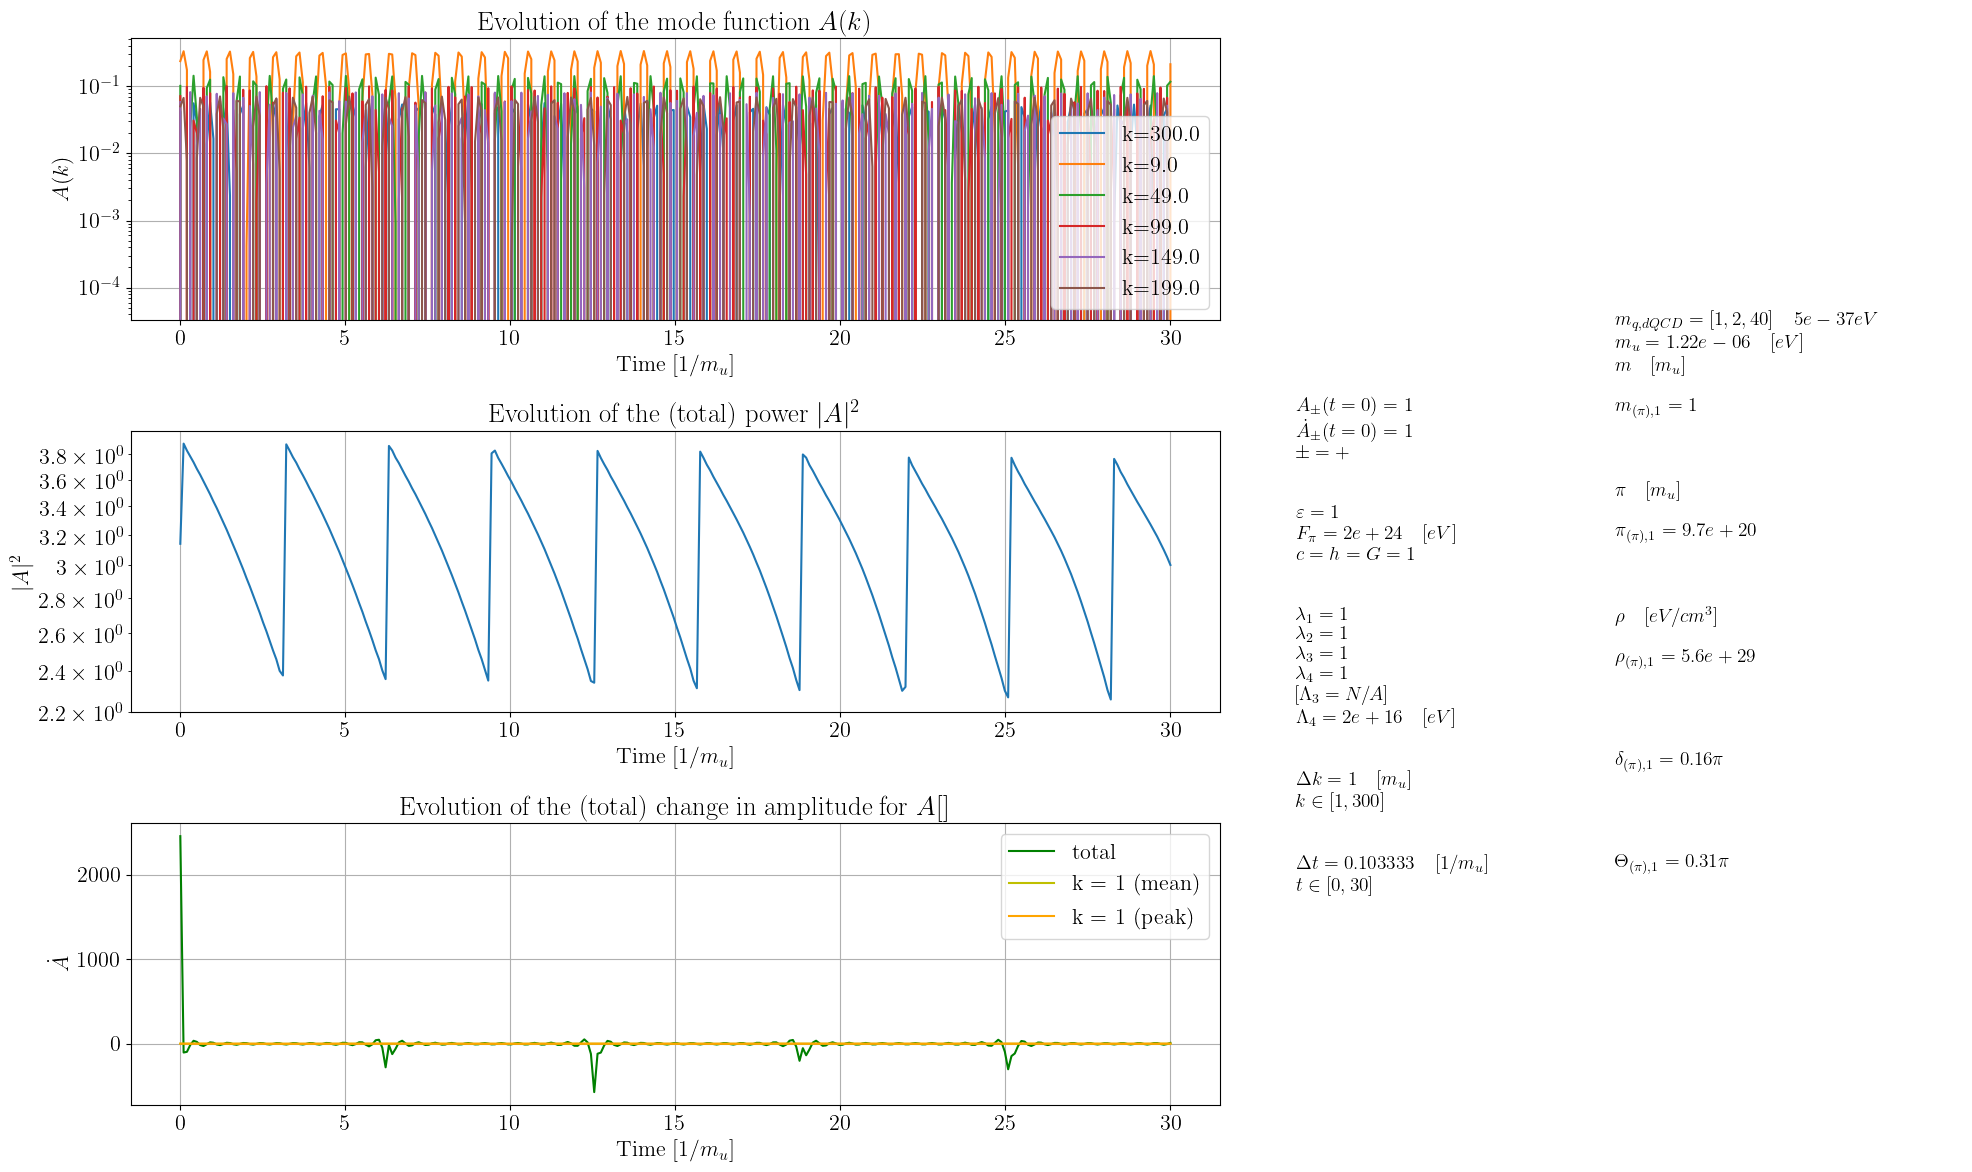

In [17]:
# Plot results (Amplitudes)
k_peak, k_mean = get_peak_k_modes(solutions, k_values_in=k_values, write_to_params=True)

if debug_level > 0:
    print('max (peak) k mode: ' + str(k_peak))
    print('max (mean) k mode: ' + str(k_mean))

# Plot the solution
plt = make_amplitudes_plot(params, units, solutions)
result_plots['amps'] = plt.gcf()
plt.show()

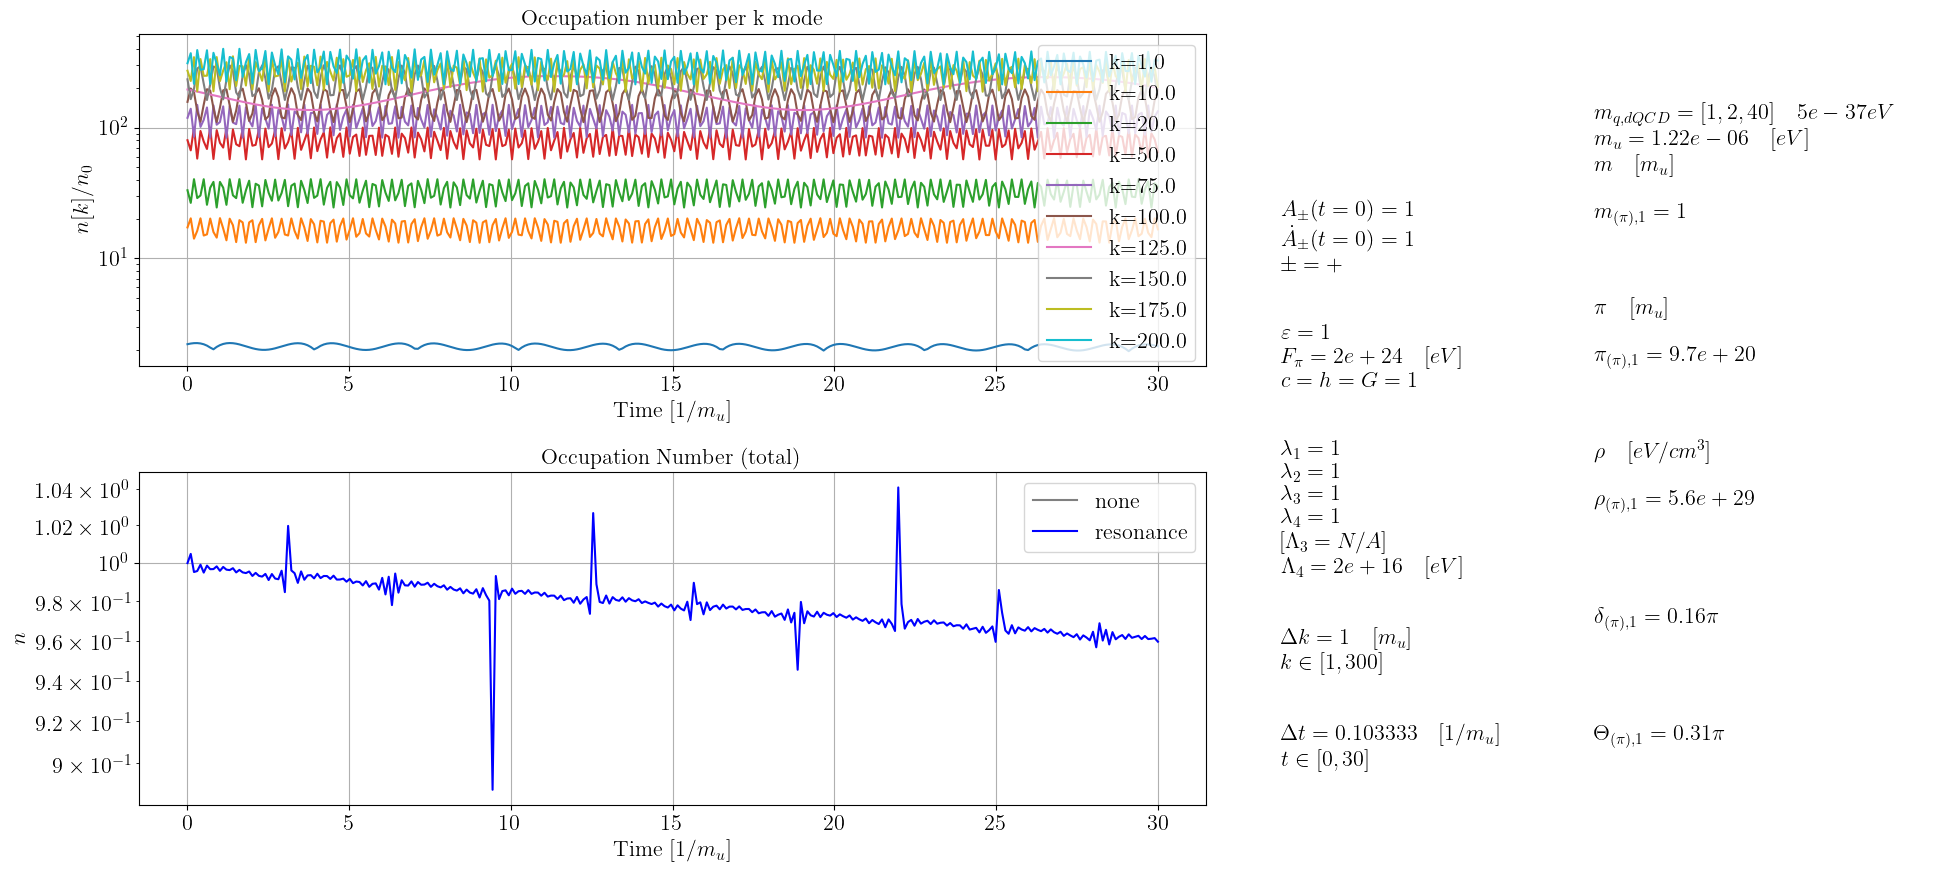

n_tot in range [6.23e+04, 7.30e+04]


In [18]:
# Plot the occupation numbers

override_n_k = False
# Override particle occupation number function
if override_n_k:
    # Particle number for k_mode value at index i
    n_k_local = lambda k, A, Adot, Im=None: (1/2)*(k**2 * np.abs(A)**2 + np.abs(Adot) + k)
else:
    from piaxi_utils import n_k
    n_k_local = n_k

# VERY DEPRECATED
if False:
    # TODO: Verify units in below equation
    k_to_w_old = np.float64(4.555e25) # 2πc/hbar [(Hz/eV)*(cm/s)]
    w_old = lambda i, k_u=k0, c=c_raw, h=h_raw, k_vals=k_values: np.abs(k_vals[i]*k_u*(2*np.pi/h))
    n_old = lambda i, w, solns, A=A_i, Adot=Adot_i: (w(i)/2) * (((np.square(np.abs(Adot(i))))/(np.square(w(i)))) + np.square(np.abs(A(i)))) - (1/2)
    
times = t

scale_n = True
plt, params, t_res, n_res = make_occupation_num_plots(params, units, solutions, numf_in=n_k_local, times_in=times, scale_n=scale_n, write_to_params=True, tex_fmt=use_tex_format)
n_tot = sum_n_p(n_k_local, params, solutions, k_values, times)

tot_res = params['res_class']
result_plots['nums'] = plt.gcf()
plt.show()

print('n_tot in range [%.2e, %.2e]' % (min(n_tot), max(n_tot)))
if 'res' in tot_res and debug_level > 2:
    print('resonance classification begins at t = %.2f, n = %.2e' % (t_res, n_res))

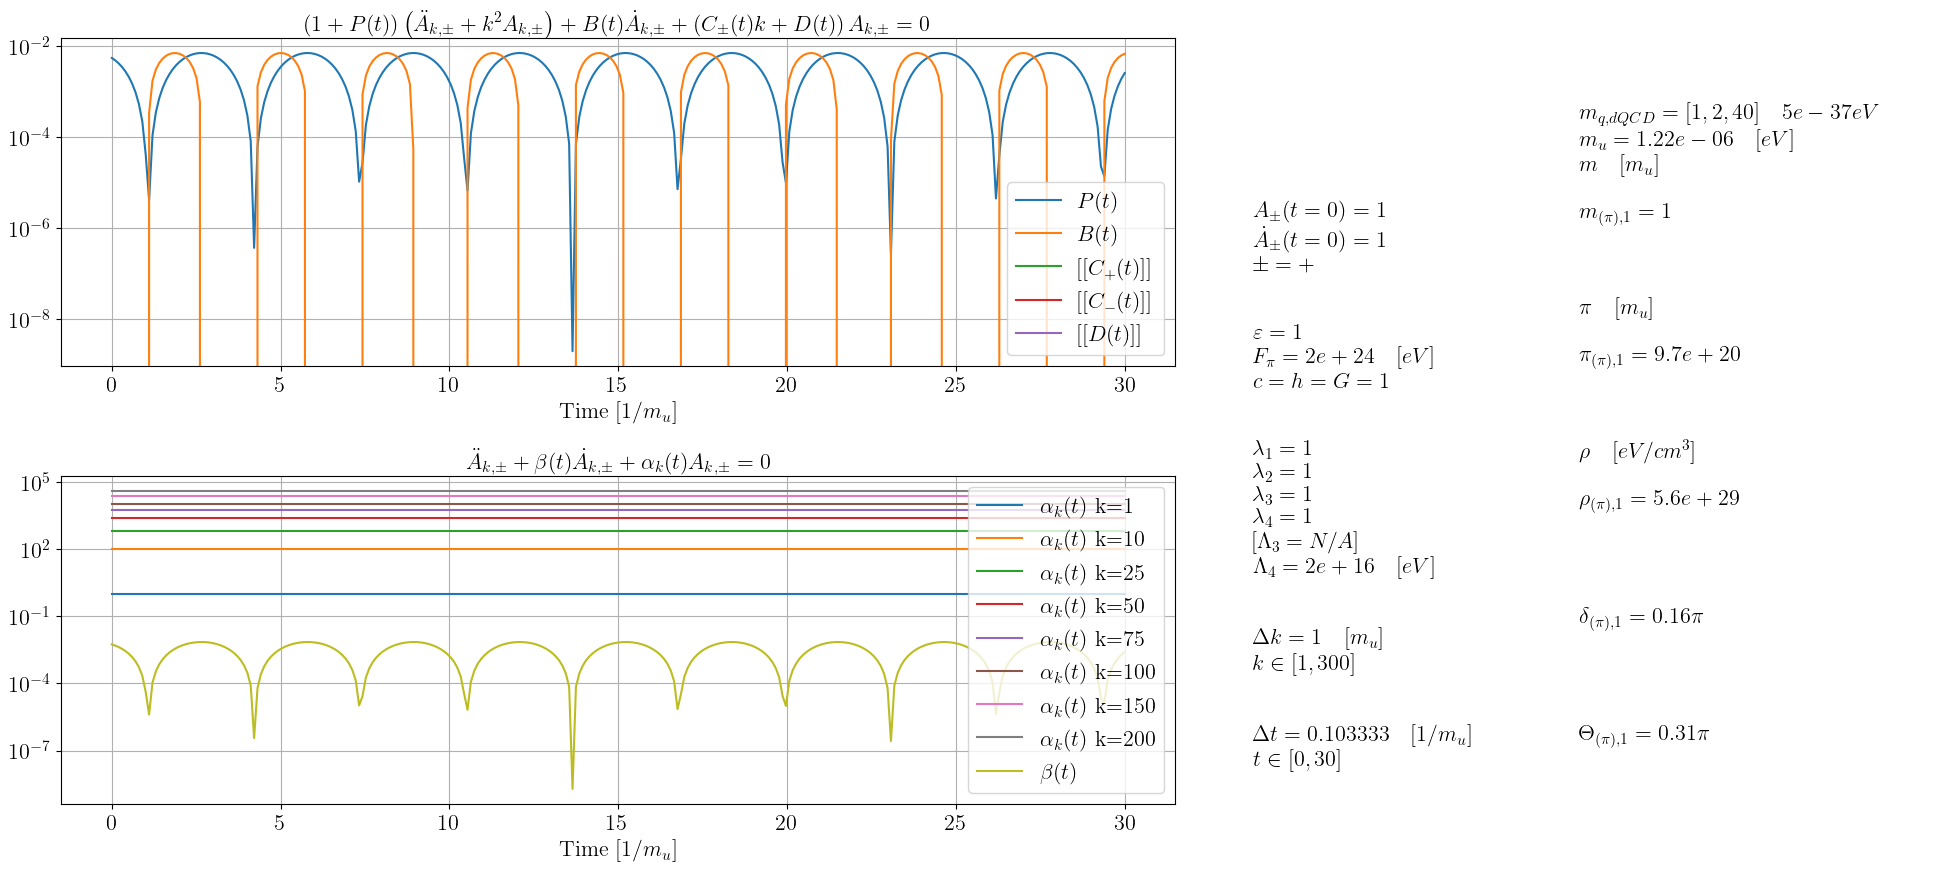

P(t) range: [1.9e-09, 7.1e-03]
B(t) range: [-7.1e-03, 7.1e-03]
C(t) range: [nan, nan] for + case 
C(t) range: [nan, nan] for - case 
D(t) range: [nan, nan]
------------------------------------------------------
Alpha(t,k) range: [1.0e+00, 1.0e+00] when k = 1
Alpha(t,k) range: [1.0e+02, 1.0e+02] when k = 10
Alpha(t,k) range: [4.0e+02, 4.0e+02] when k = 20
Alpha(t,k) range: [2.5e+03, 2.5e+03] when k = 50
Alpha(t,k) range: [5.6e+03, 5.6e+03] when k = 75
Alpha(t,k) range: [1.0e+04, 1.0e+04] when k = 100
Alpha(t,k) range: [1.6e+04, 1.6e+04] when k = 125
Alpha(t,k) range: [2.2e+04, 2.2e+04] when k = 150
Alpha(t,k) range: [3.1e+04, 3.1e+04] when k = 175
Alpha(t,k) range: [4.0e+04, 4.0e+04] when k = 200
Beta(t)    range: [1.9e-09, 7.1e-03]


In [19]:
# Plot results (Oscillating coefficient values)
plt = make_coefficients_plot(params, units, P, B, C, D, A_pm, k0, tex_fmt=use_tex_format)
result_plots['coeffs'] = plt.gcf()
plt.show()

if debug_level == 2:
    print_coefficient_ranges(params, P, B, C, D)
elif debug_level > 2:
    print_coefficient_ranges(params, P, B, C, D, print_all=True)

params['class']:
 none


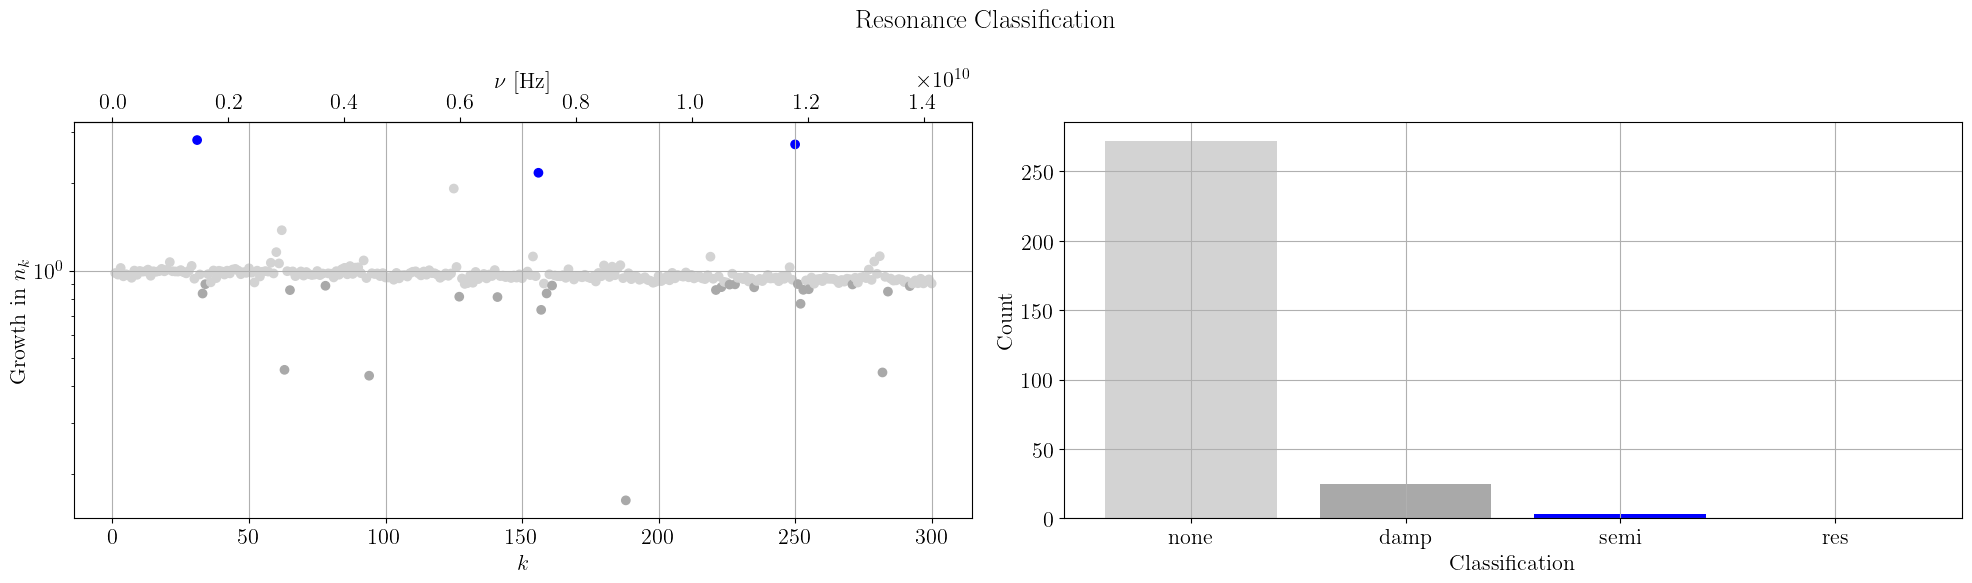

In [20]:
if debug_level > 7:
    print('params:\n', params, '\n')
if debug_level > 2:
    print('params[\'class\']:\n', params['res_class'])
    if debug_level > 6:
        print('params[\'k_class_arr\']:\n', params['k_class_arr'])
        print('k_ratio:\n', k_ratio(np.mean, t_sens, A_sens))

# E^2 = p^2c^2 + m^2c^4
# Assuming k, m are given in units of eV/c and eV/c^2 respectively
#k_to_Hz = lambda ki, mi=0, m_0=m0, e=e: 1/h * np.sqrt((ki*k0*e)**2 + ((mi*m_0 * e))**2)
k_to_Hz_local = lambda ki, k0=k0_raw, h=h_raw, c=c_raw: k_to_Hz(ki, k0, h, c)
#Hz_to_k = lambda fi, mi=0, m_0=m0, e=e: 1/(e*k0) * np.sqrt((h * fi)**2 - ((mi*m_0 * e))**2)
Hz_to_k_local = lambda fi, k0=k0_raw, h=h_raw, c=c_raw: Hz_to_k(fi, k0, h, c)

# Plot k-mode power spectrum (TODO: Verify power spectrum calculation)
plt = make_resonance_spectrum(params, units, k_to_Hz_local, Hz_to_k_local, tex_fmt=use_tex_format)
result_plots['resonance'] = plt.gcf()
plt.show()

class_sens = 0.1
# Known observable frequency range and bandwidth classification
res_freq_label, res_freq_class = get_frequency_class(k_peak, k_to_Hz_local, tot_res, verbosity=verbosity)
res_band_min, res_band_max, res_band_class = get_resonance_band(k_values, params['k_class_arr'], k_to_Hz_local, class_sens, verbosity=verbosity)

params['res_freq'] = k_to_Hz_local(k_peak)
params['res_freq_label'] = res_freq_label
params['res_band'] = [res_band_min, res_band_max]
params['res_freq_class'] = res_freq_class
params['res_band_class'] = res_band_class

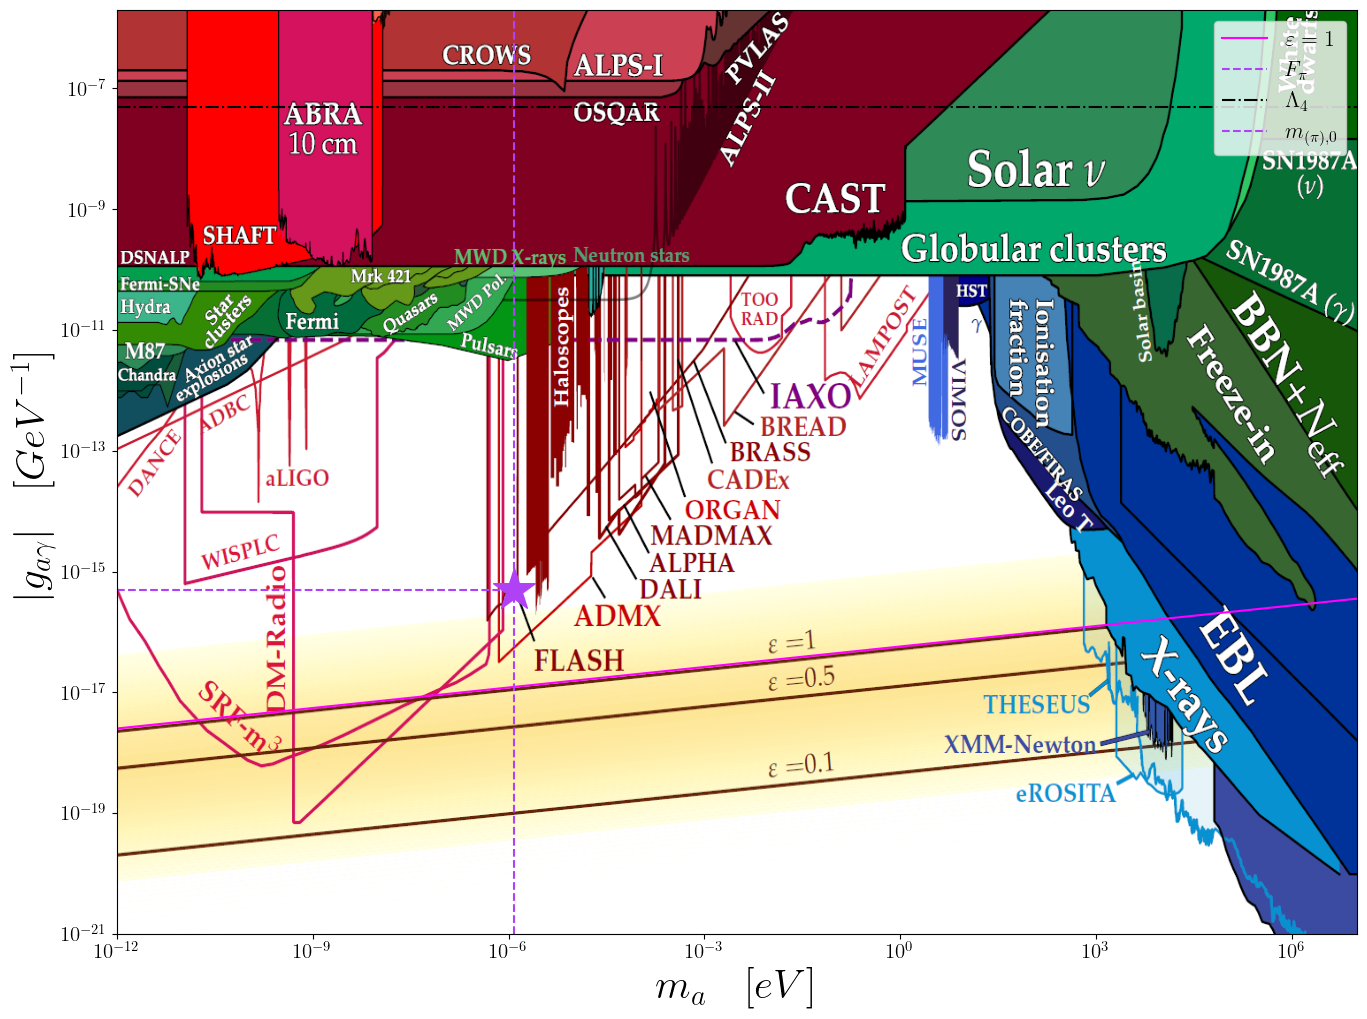

In [21]:
plt = plot_ALP_survey(params, verbosity=verbosity, tex_fmt=use_tex_format)

result_plots['alp'] = plt.gcf()
    
plt.show()

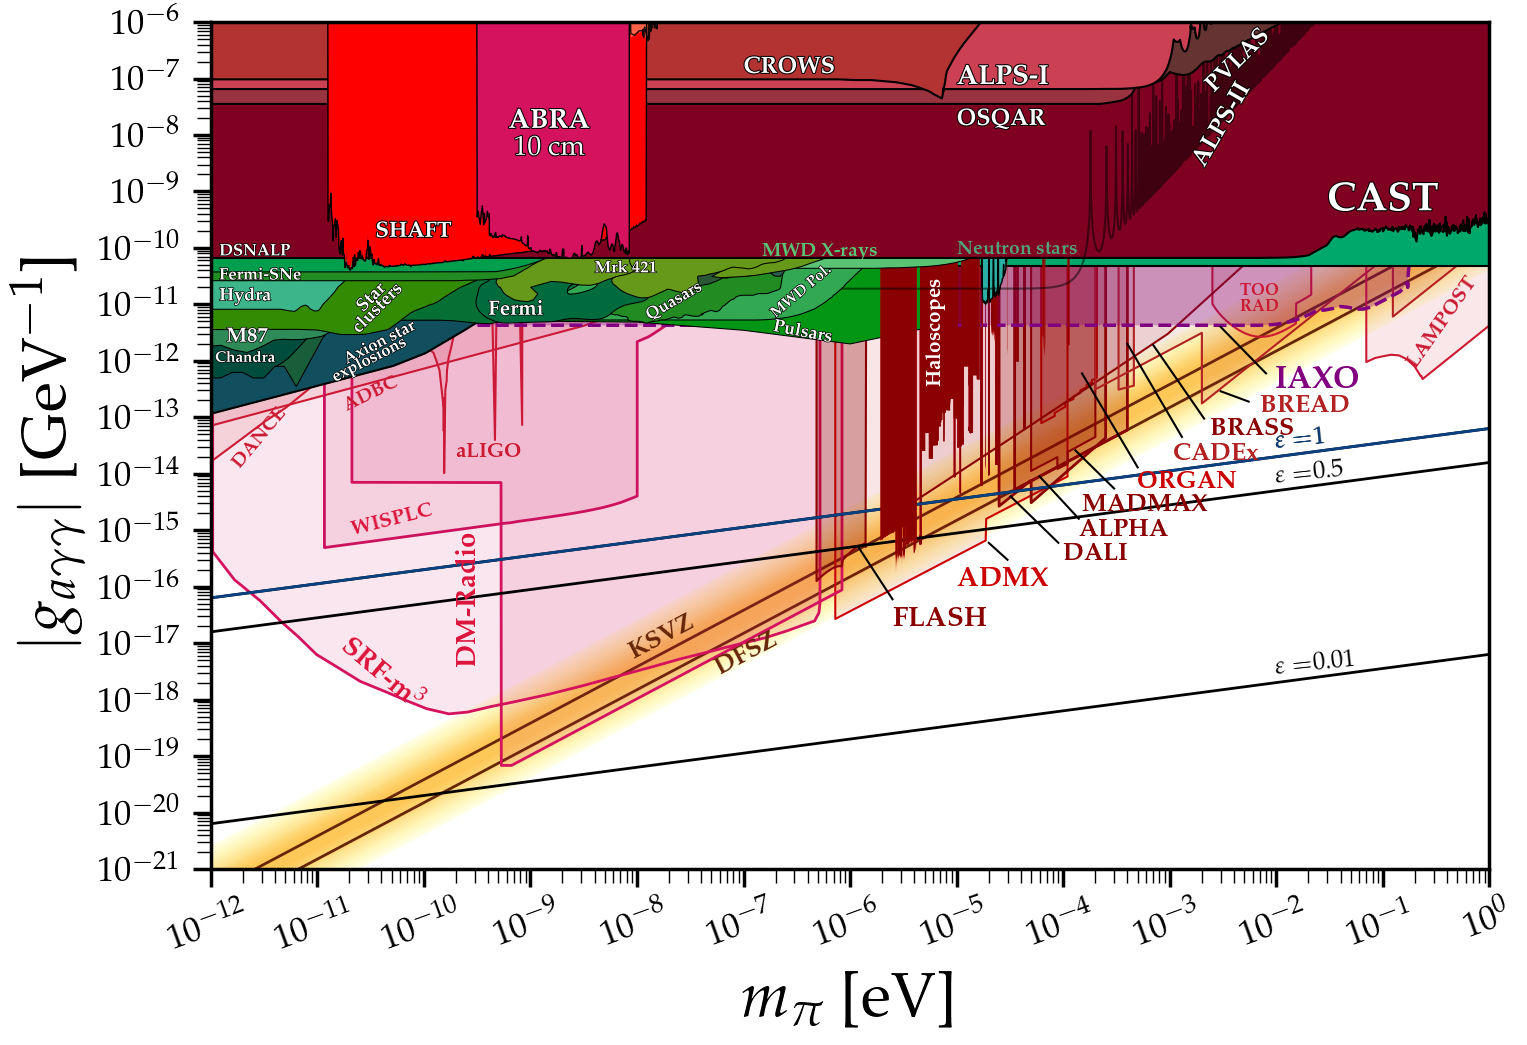

In [39]:
tools_dir = os.path.abspath(os.path.join('./tools'))
if tools_dir not in sys.path:
    sys.path.append(tools_dir)

from PlotFuncs import FigSetup, AxionPhoton, MySaveFig, BlackHoleSpins, FilledLimit, line_background


fig,ax = FigSetup(Shape='Rectangular',ylab='$|g_{a\gamma\gamma}|$ [GeV$^{-1}$]',mathpazo=True)


AxionPhoton.QCDAxion(ax,C_center=abs(5/3-1.92)*(44/3-1.92)/2,C_width=0.7,vmax=1.1,)
AxionPhoton.Cosmology(ax)
AxionPhoton.StellarBounds(ax)
AxionPhoton.SolarBasin(ax)
AxionPhoton.Haloscopes(ax,projection=True,BASE_arrow_on=False)
AxionPhoton.Helioscopes(ax,projection=True)
AxionPhoton.LSW(ax,projection=True)
AxionPhoton.LowMassAstroBounds(ax,projection=True)

# Dark matter astro/cosmo bounds:
AxionPhoton.ALPdecay(ax,projection=True)
AxionPhoton.NeutronStars(ax)
AxionPhoton.AxionStarExplosions(ax)

# TODO: reverse engineer this, pretty it up
AxionPhoton.piAxion(ax,epsilon=1,lambda1=1,theta=1,label_mass=1e-2,C_logwidth=10,cmap='Greys',fs=18,rot = 6.0,
                C_center=1,C_width=1.2,vmax=0.9)
AxionPhoton.piAxion(ax,epsilon=0.5,lambda1=1,theta=1,label_mass=1e-2,C_logwidth=10,cmap='Greys',fs=18,rot = 6.0,
                C_center=1,C_width=1.2,vmax=0.9)
AxionPhoton.piAxion(ax,epsilon=0.01,lambda1=1,theta=1,label_mass=1e-2,C_logwidth=10,cmap='Greys',fs=18,rot = 6.0,
                C_center=1,C_width=1.2,vmax=0.9)

AxionPhoton.piAxion(ax,epsilon=eps,lambda1=l1,theta=1,label_mass=1e-2,C_logwidth=10,cmap='GnBu',fs=18,rot = 6.0,
                C_center=1,C_width=1.2,vmax=0.9)

In [ ]:
fit_eps = False
if fit_eps:
    pts = [(0.1,-19.9), (0.5,-18.6), (1,-17.9)]
    fit_res = fit_epsilon_relation(pts, plot_fit=True)
    if debug_level >= 0:
        print('y = %.3f log_10(10x + %.3f) + %.3f' % (fit_res[0], fit_res[1], fit_res[2]))

In [ ]:
# Optionally save results of this run to data directory
save_input_params = True
save_integrations = True
save_output_plots = True
use_longterm_data = False

if save_output_files:
    storage_path = data_path if use_longterm_data else '~/scratch'
    output_dir   = '/'.join(storage_path.split('/')) + '/' + version + '/' + config_name + '/'
    output_name  = '_'.join([config_name, phash])
    
    save_results(output_dir, output_name, params, solutions, result_plots, verbosity=debug_level, save_format='pdf',
                 save_params=save_input_params, save_results=save_integrations, save_plots=save_output_plots, 
                 save_coefficients=True, P=P, B=B, C=C, D=D)
    
    # Save plots (PDF or HTML or PNG or Notebook?)
    # (TODO)